<a href="https://colab.research.google.com/github/bernarducs/caged_time_series/blob/master/Estudo_estoques_formais_PERNAMBUCO_SARIMAX_com_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objetivo
### Abaixo, utilizaremos funções que buscarão os melhores parâmetros para modelagem do método ARIMAX com fator sazonal, usando como variável exógena o Ibc.

Based on article: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

## Pacotes

In [ ]:
from math import sqrt
from itertools import product
import pandas as pd

In [ ]:
# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [ ]:
# multiprocessing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [ ]:
# stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

## Datasets

#### Estoques

In [ ]:
file_path = "/content/drive/My Drive/Colab Notebooks/emprego/bases/estoque_pe.xlsx"
df = pd.read_excel(file_path, index_col='ano_mes')
df.columns = ['estoques']
df.index = pd.to_datetime(df.index, format="%Y%m")
df.head()

,estoques
ano_mes,
2010-12-01,1168196
2011-01-01,1162322
2011-02-01,1164519
2011-03-01,1157459
2011-04-01,1155681


#### Ibc

In [ ]:
file_ibcpe = '/content/drive/My Drive/Colab Notebooks/emprego/bases/IBCR-PE.csv'
df_ibc = pd.read_csv(file_ibcpe, sep=';', dtype={'data': 'str', 'indice':'float', 'indice_ajus':'float'}, decimal=',')
df_ibc['data'] = pd.to_datetime(df_ibc.data, format="%m/%Y")
df_ibc.set_index('data', inplace=True)
exog = df_ibc.loc['2010-12-01':]
exog.head()

,indice,indice_ajus
data,,
2010-12-01,156.09,140.27
2011-01-01,136.36,138.96
2011-02-01,134.19,140.69
2011-03-01,136.76,141.05
2011-04-01,134.15,141.02


#### Saldo

In [ ]:
file_path2 = "/content/drive/My Drive/Colab Notebooks/emprego/bases/saldo_caged_pe.xlsx"
df_saldo = pd.read_excel(file_path2)
df_saldo.columns = ['ano', 'saldo']
df_saldo.set_index('ano', inplace=True)
df_saldo.index = pd.to_datetime(df_saldo.index, format="%Y")
df_saldo.tail()

,saldo
ano,
2016-01-01,-47617
2017-01-01,-6498
2018-01-01,4091
2019-01-01,9696
2020-01-01,-63101


## Rotinas

Aqui temos funções para o sarima em 1 passo (faz a predição para t+1). A próxima função é raiz quadrada dos erros médios e por fim a função responsável por separação do dataset entre teste e treino.

In [ ]:
# one-step sarima forecast
def sarimax_forecast(history, config, exog=None):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, exog=exog, order=order, seasonal_order=sorder, trend=trend, 
                 enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict()
	return yhat
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, percent_test=0.25):
  n_test = int(len(data) * percent_test)
  return data[:-n_test], data[-n_test:]

Aqui usamos a funções acima retornando o quadrado dos desvios.

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, percent_test, cfg, exog=None):

  # split dataset
  train, _ = train_test_split(data, percent_test)

  if exog:
    exog, _ = train_test_split(exog, percent_test)

  # fit model and make forecast for history
  yhat = sarimax_forecast(train, cfg, ex_train)

  # estimate prediction error
  error = measure_rmse(train, yhat)
  return error  

Avalia qual a melhor configuração de parâmetros `cfg` tem a melhor avaliação, ou seja, o menor erro.

In [ ]:
def score_model(data, n_test, cfg, exog=None, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg, exog)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg, exog)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model{}: {:.2f}'.format(key, result))
  return (key, result)

In [ ]:
# grid search configs
def grid_search(data, n_test, cfg_list, exog=None, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg, exog) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg, exog) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

In [ ]:
# evaluating grid search results for test data
def grid_search_test_results(data, scores, exog=None, ntop_scores=5):

  if ntop_scores > len(scores):
    ntop_scores = 5

  scores_test = list()
  _, test = train_test_split(data, percent_test=0.4)
  _, ex_test = train_test_split(exog, percent_test=0.4)  

  for cfg_str, _ in scores[:ntop_scores]:
    cfg = eval(cfg_str)
    with catch_warnings():
      filterwarnings("ignore")
      yhat = sarimax_forecast(test, cfg, ex_test)
    error = measure_rmse(test, yhat)
    result = (cfg_str, error)
    print(result)
    scores_test.append(result)
  
  scores_test.sort(key=lambda tup: tup[1])
  return scores_test

In [ ]:
def plot_model(data, cfg, exog=None):
  order = cfg[0]
  s_order = cfg[1]
  trend = cfg[2]
  sarimax_pred = SARIMAX(
      endog=df, exog=exog, order=order, seasonal_order=s_order, trend=trend,
      enforce_stationarity=False, enforce_invertibility=False)

  model_sarimax_pred = sarimax_pred.fit(disp=False)

  previsao_sarimax = model_sarimax_pred.predict()

  error = measure_rmse(df, previsao_sarimax)
  print('Error:', error)

  plt.figure(figsize=(22, 10))
  plt.plot(previsao_sarimax[10:], label = 'forecast')
  plt.plot(df[10:], label = 'target')
  plt.title('Target x Forecast')
  plt.legend()
  plt.show()

In [ ]:
def sarima_configs(seasonal=[12]):
  models = list()
  # define config lists
  p_params = [0, 1, 2]
  d_params = [0, 1]
  q_params = [0, 1, 2]
  t_params = ['n','c','t','ct']
  P_params = [0, 1, 2]
  D_params = [0, 1]
  Q_params = [0, 1]
  m_params = seasonal
  # create config instances
  for p, d, q, t, P, D, Q, m in product(p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params):
    cfg = [(p,d,q), (P,D,Q,m), t]
    models.append(cfg)
  return models

## Gerando modelo

In [ ]:
cfg_list = sarima_configs(seasonal=[12])
scores = grid_search(df, 0.25, cfg_list)

 > Model[(0, 0, 0), (0, 0, 0, 12), 'n']: 35916.18
 > Model[(0, 0, 0), (0, 1, 0, 12), 'n']: 37643.80
 > Model[(0, 0, 0), (0, 0, 1, 12), 'n']: 34685.28
 > Model[(0, 0, 0), (1, 0, 0, 12), 'n']: 35033.00
 > Model[(0, 0, 0), (1, 0, 1, 12), 'n']: 34592.32
 > Model[(0, 0, 0), (0, 1, 1, 12), 'n']: 78465.02
 > Model[(0, 0, 0), (1, 1, 0, 12), 'n']: 190942.83
 > Model[(0, 0, 0), (2, 0, 0, 12), 'n']: 32240.61
 > Model[(0, 0, 0), (1, 1, 1, 12), 'n']: 33821.51
 > Model[(0, 0, 0), (2, 0, 1, 12), 'n']: 29843.21
 > Model[(0, 0, 0), (0, 0, 0, 12), 'c']: 35930.38
 > Model[(0, 0, 0), (0, 0, 1, 12), 'c']: 34686.16
 > Model[(0, 0, 0), (0, 1, 0, 12), 'c']: 36632.37
 > Model[(0, 0, 0), (2, 1, 0, 12), 'n']: 233673.81
 > Model[(0, 0, 0), (0, 1, 1, 12), 'c']: 66883.37
 > Model[(0, 0, 0), (1, 0, 0, 12), 'c']: 35037.44
 > Model[(0, 0, 0), (1, 0, 1, 12), 'c']: 34593.41
 > Model[(0, 0, 0), (1, 1, 0, 12), 'c']: 179232.29
 > Model[(0, 0, 0), (1, 1, 1, 12), 'c']: 194573.46
 > Model[(0, 0, 0), (2, 1, 1, 12), 'n']: 39660

In [ ]:
scores[:3]

In [ ]:
test_scores = test_grid_search_results(df, exog, scores, ntop_scores=2)

In [ ]:
test_scores

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Error: 17216.282104952123


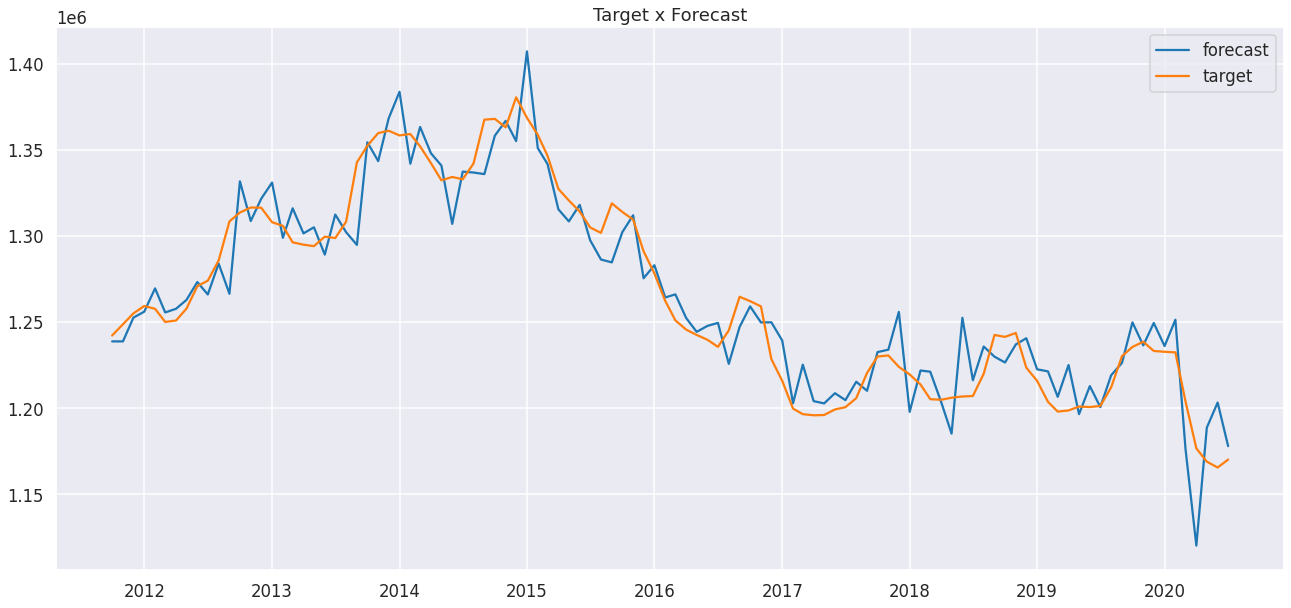

In [ ]:
plot_model(df, exog, eval(test_scores[0][0]))

___

## Previsão

In [ ]:
cfg= eval(test_scores[0][0])
# cfg = [(0, 1, 2), (0, 0, 1, 12), 't']
order = cfg[0]
s_order = cfg[1]
trend = cfg[2]
sarimax_pred = SARIMAX(
    endog=df, exog=df_ibc.indice_ajus, order=order, seasonal_order=s_order, trend=trend,
    enforce_stationarity=False, enforce_invertibility=False)

model_sarimax_pred = sarimax_pred.fit(disp=False)

fcast_sarimax = model_sarimax_pred.get_forecast(5, exog=df_ibc.indice_ajus[-5:].values.reshape(-1, 1))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
df_fcast = pd.concat([model_sarimax_pred.predict(), fcast_sarimax.predicted_mean], axis=0)

In [ ]:
df_fcast.name = 'fcast'
df_fcast = pd.concat([df_fcast, fcast_sarimax.conf_int()], axis=1)
df_fcast.tail()

,fcast,lower estoques,upper estoques
2020-08-01,1.194649e+06,1.161092e+06,1.228207e+06
2020-09-01,1.110412e+06,1.063742e+06,1.157083e+06
2020-10-01,1.131321e+06,1.079486e+06,1.183155e+06
2020-11-01,1.184591e+06,1.129819e+06,1.239363e+06
2020-12-01,1.199323e+06,1.142515e+06,1.256132e+06


In [ ]:
previsoes_sarimax = pd.concat(
    [df['estoques'], df_fcast],
    axis=1)

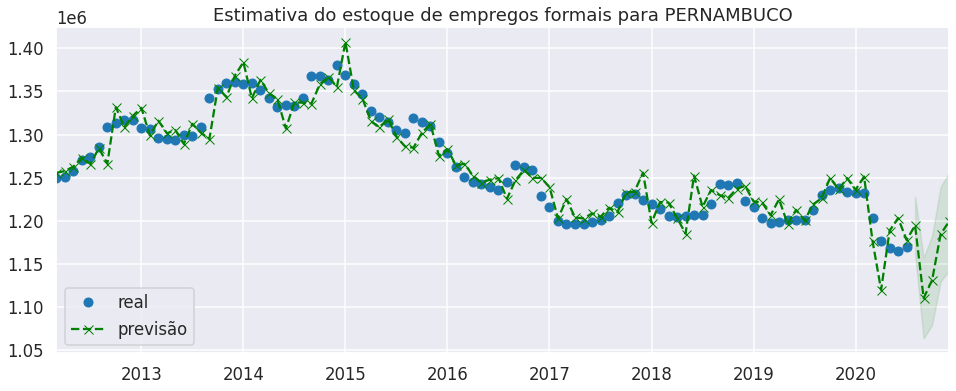

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
previsoes_sarimax.estoques.loc['2012-03-01':].plot(ax=ax, style='o', label='real')

previsoes_sarimax.fcast.loc['2012-03-01':].plot(ax=ax, style='g--x', label='previsão')

ax.fill_between(
    previsoes_sarimax.index, 
    previsoes_sarimax.iloc[:,2], 
    previsoes_sarimax.iloc[:,3], color='g', alpha=0.1)

plt.title('Estimativa do estoque de empregos formais para PERNAMBUCO')
legend = ax.legend(loc='lower left')

Até o fim do ano o saldo será:

In [ ]:
fcast_sarimax.predicted_mean[-1] - df.estoques[-1]

29267.315637353575

In [ ]:
pred2020df = pd.DataFrame(df_saldo.saldo[-1] + fcast_sarimax.predicted_mean[-1] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df.index.name = "Ano"
pred2020df.index = pd.to_datetime(pred2020df.index, format="%Y")

In [ ]:
df_saldo_pred = pd.concat([df_saldo[1:][:-1], pred2020df], axis=0)
df_saldo_pred['saldo'] = df_saldo_pred.saldo.astype('int')
df_saldo_pred.index.name = 'data'

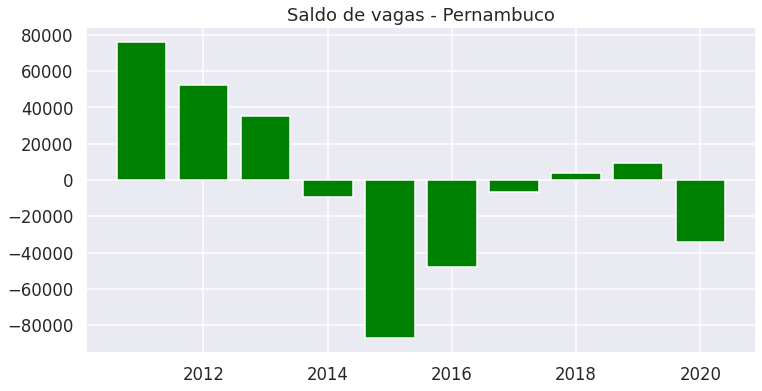

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred.index.year, df_saldo_pred.saldo, color='g')
plt.title('Saldo de vagas - Pernambuco')
plt.show();

In [ ]:
df_saldo_pred.to_csv("/content/drive/My Drive/Colab Notebooks/emprego/bases/saldo_pe_pred.csv")

In [ ]:
df_saldo_pred.groupby(df_saldo_pred.index.year).sum()

,saldo
data,
2011,76082
2012,52256
2013,35068
2014,-9566
2015,-87207
2016,-47617
2017,-6498
2018,4091
2019,9696


### Otimista

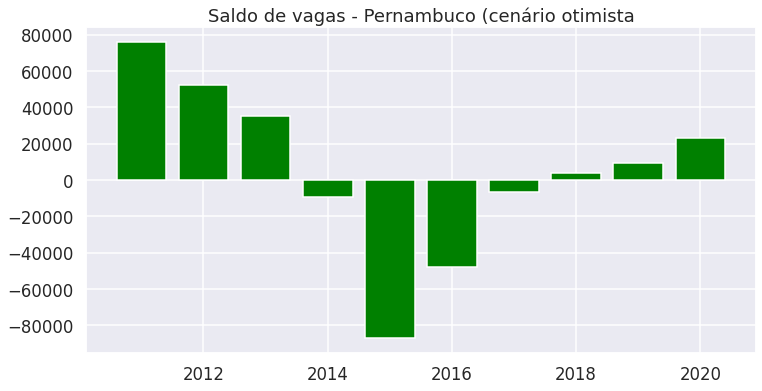

In [ ]:
pred2020df_otimista = pd.DataFrame(df_saldo.saldo[-1] + df_fcast.iloc[-1:, 2][0] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df_otimista.index.name = "Ano"
pred2020df_otimista.index = pd.to_datetime(pred2020df_otimista.index, format="%Y")

df_saldo_pred_otimista = pd.concat([df_saldo[1:][:-1], pred2020df_otimista], axis=0)
df_saldo_pred_otimista['saldo'] = df_saldo_pred_otimista.saldo.astype('int')
df_saldo_pred_otimista.index.name = 'data'

plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred_otimista.index.year, df_saldo_pred_otimista.saldo, color='g')
plt.title('Saldo de vagas - Pernambuco (cenário otimista')
plt.show();

### Pessimista

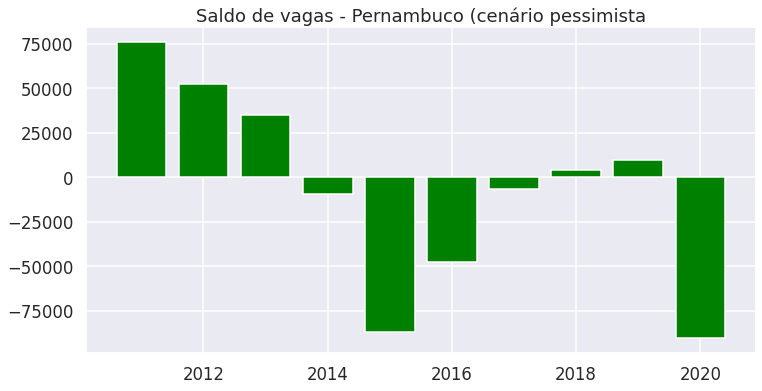

In [ ]:
pred2020df_pess = pd.DataFrame(df_saldo.saldo[-1] + df_fcast.iloc[-1:, 1][0] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df_pess.index.name = "Ano"
pred2020df_pess.index = pd.to_datetime(pred2020df_pess.index, format="%Y")

df_saldo_pred_pess = pd.concat([df_saldo[1:][:-1], pred2020df_pess], axis=0)
df_saldo_pred_pess['saldo'] = df_saldo_pred_pess.saldo.astype('int')
df_saldo_pred_pess.index.name = 'data'

plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred_pess.index.year, df_saldo_pred_pess.saldo, color='g')
plt.title('Saldo de vagas - Pernambuco (cenário pessimista')
plt.show();